In [613]:
import numpy as np
import matplotlib.pyplot as plt

In [614]:
def initialize_membership_matrix(num_samples, num_clusters):
    membership_mat = np.random.rand(num_clusters, num_samples)
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

def initial_centroids(num_clusters, num_features):
    return np.random.rand(num_clusters, num_features)
    

In [615]:
def epsilon_insensitive_loss(y_true, y_pred, epsilon):
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)
    # Apply epsilon-insensitive penalty
    loss = np.maximum(0, errors - epsilon)
    return np.mean(loss)

In [616]:
def update_membership_matrix(data, centroids, num_clusters, epsilon, m):
    # Update the membership matrix
    num_samples = data.shape[0]
    membership_mat = np.zeros((num_clusters, num_samples)).astype('float32')
    for i in range(num_samples):
        for k in range(num_clusters):
            # Compute the distance between the sample and the centroid
            # Avoid division by zero
            membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/1-m)) / (np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/m-1)))
    # Normalize the membership matrix
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

In [617]:
from scipy.optimize import minimize


EPSILON = .01
DATA = None
L    = None


def objective(x):
    global EPSILON 
    global DATA
    global L
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    temp = 0
    for k in range(len(a)):
        temp += (a[k] - b[k])*DATA[k,L]
    return temp + sum(a + b) * EPSILON

def constraint(x):
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    return sum(a) - sum(b)

def Lambda(num_samples, membership_mat, i_index, m):
    initial_guess = [0.] * num_samples*2
    bounds_a = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds_b = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds = np.concatenate((bounds_a, bounds_b))
    constraint_eq = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraint_eq)

    return result.x[:len(result.x)//2], result.x[len(result.x)//2:]

def update_centroid(data, num_samples, num_features, num_clusters, centroids, epsilon, membership_mat, m):
    global EPSILON, DATA, L
    EPSILON = epsilon
    DATA = data

    for i in range(num_clusters):
        for j in range(num_features):
            L = j
            l1, l2 = Lambda(num_samples, membership_mat, i, m)
            f, s = 0, 0
            for ns in range(num_samples):
                if 0<l1[ns]<membership_mat[i, ns]**m:
                    f += data[ns][j] + epsilon
                if 0<l2[ns]<membership_mat[i, ns]**m:
                    s += data[ns][j] - epsilon
            # print(f, end=":")
            # print(s)
            centroids[i][j] = 3.5*(f+s) / np.unique(np.concatenate((l1, l2))).shape[0]
    
    return centroids
        

In [618]:
def fuzzy_cmeans(data, num_clusters, max_iter, epsilon, m):
    num_samples, num_features = data.shape
    cen_mat = initial_centroids(num_clusters, num_features)
    for _ in range(max_iter):
        mem_mat = update_membership_matrix(data, cen_mat, num_clusters, epsilon, m)
        cen_mat = update_centroid(data, num_samples, num_features, num_clusters, cen_mat, epsilon, mem_mat, m)
    print(cen_mat)
    print(mem_mat)
    return cen_mat, mem_mat
        

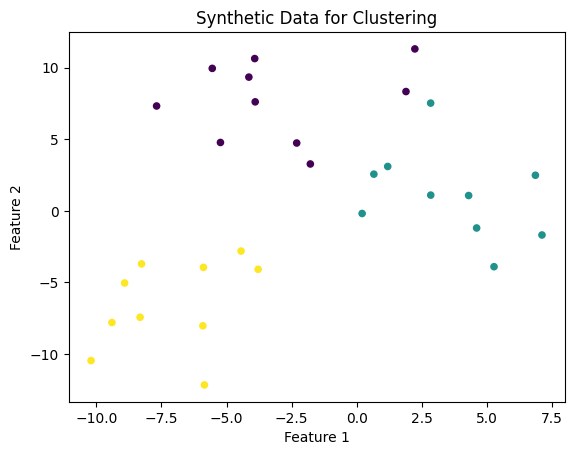

[[-2.57353313 -7.78764492]
 [-3.73344376  2.45891528]
 [ 0.93907931 -0.00975065]]
[[8.94295517e-04 3.08882981e-08 2.94197389e-06 1.26520291e-07
  9.33197128e-08 9.42421984e-03 1.64697703e-04 1.00000000e+00
  4.31543565e-04 9.93888319e-01 1.34571110e-06 9.99375939e-01
  2.65719269e-08 2.64467369e-03 5.48315700e-04 5.81460972e-06
  9.96950388e-01 3.43039464e-05 4.45711613e-02 9.99998689e-01
  9.99898791e-01 9.99977529e-01 9.99924660e-01 9.75302828e-06
  5.45498158e-04 1.42698497e-01 9.99008954e-01 1.13602746e-05
  5.84575682e-05 9.99997556e-01]
 [9.97809350e-01 1.14445731e-06 1.05018005e-01 9.99631166e-01
  9.99702811e-01 9.88401830e-01 3.39103267e-02 9.29929536e-11
  9.36679363e-01 7.08710693e-04 9.74590439e-05 4.74004592e-05
  3.63208414e-06 8.76073318e-04 9.98822570e-01 1.02934882e-01
  6.60838632e-05 9.98996496e-01 9.46852088e-01 9.89498332e-08
  1.09552120e-05 2.11350311e-06 1.31893114e-06 2.48168308e-05
  6.72219147e-04 8.55855167e-01 1.39217780e-04 9.93143320e-01
  9.99847174e-01 

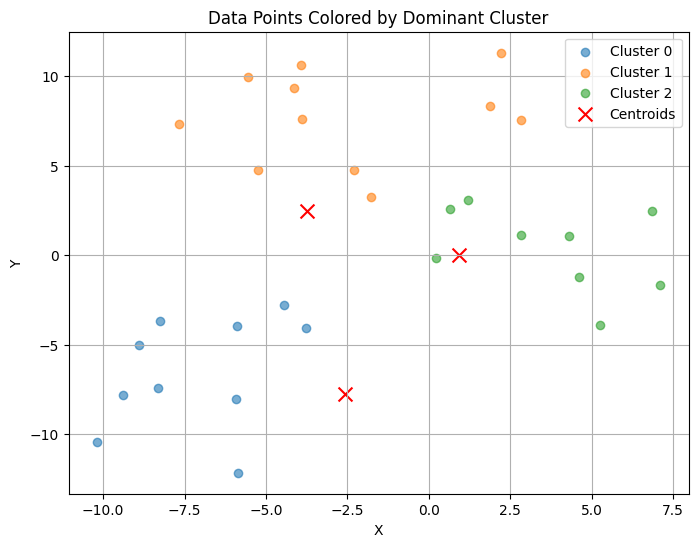

In [619]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

num_clusters=3
num_samples = 30

# Generate synthetic data with clusters
X, y = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=3.0, random_state=42)
# Visualize the generated data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
plt.title('Synthetic Data for Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


centroids ,membership_mat = fuzzy_cmeans(X, num_clusters, 20, .1, 10)


max_membership_cluster = np.argmax(membership_mat, axis=0)
# Plot data points with colors based on their corresponding centroids
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X[max_membership_cluster == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Data Points Colored by Dominant Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()